In [19]:
# === LOAD DATASET
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://raw.githubusercontent.com/fancesatria/heartastic/main/dataset/Cardiovascular_Disease_Dataset.csv")

# **A. DATA PREPROCESSING**

In [20]:
# DROP UNNECESSARY COL AND RENAME COL
df = df.drop(columns=['patientid'], errors='ignore')

df = df.rename(columns={
    'age': 'Age',
    'gender': 'Sex',
    'chestpain': 'ChestPain',
    'restingBP': 'RestBP',
    'serumcholestrol': 'Cholesterol',
    'fastingbloodsugar': 'FastingBS',
    'restingrelectro': 'RestECG',
    'maxheartrate': 'MaxHR',
    'exerciseangia': 'ExerciseAngina',
    'oldpeak': 'Oldpeak',
    'slope': 'ST_Slope',
    'noofmajorvessels': 'NumVessels',
    'target': 'HeartDisease'
})

# DROP COLUMN
df = df.drop(columns=['RestECG', 'MaxHR', 'Oldpeak', 'NumVessels', 'ST_Slope'])

print(df.head())

   Age  Sex  ChestPain  RestBP  Cholesterol  FastingBS  ExerciseAngina  \
0   53    1          2     171            0          0               0   
1   40    1          0      94          229          0               0   
2   49    1          2     133          142          0               1   
3   43    1          0     138          295          1               0   
4   31    1          1     199            0          0               0   

   HeartDisease  
0             1  
1             0  
2             0  
3             1  
4             1  


HeartDisease
1    58.0
0    42.0
Name: proportion, dtype: float64


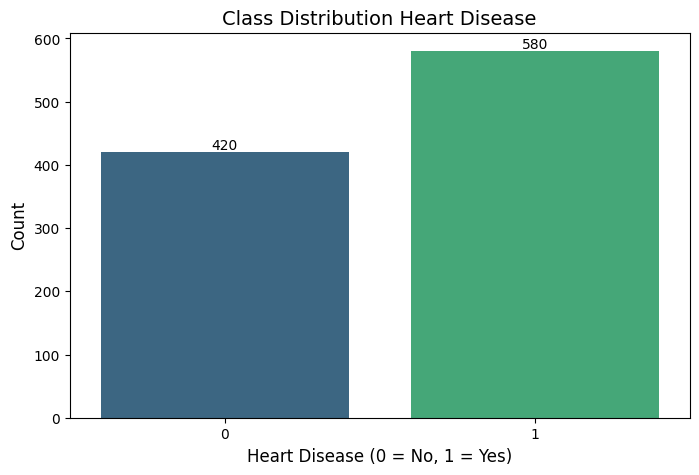

In [21]:
# DATA DISTRIBUTION CHECK
print(df['HeartDisease'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='HeartDisease', hue='HeartDisease', palette='viridis', legend=False)
plt.title("Class Distribution Heart Disease", fontsize=14)
plt.xlabel("Heart Disease (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [22]:
# CLEAN OUTLIER
from scipy.stats import mstats

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("HeartDisease")  # Exclude target

def winsorize_data(data, cols, limits=(0.05, 0.05)):
    data_copy = data.copy()
    for col in cols:
        data_copy[col] = mstats.winsorize(data_copy[col], limits=limits)
    return data_copy

df_winsorized = winsorize_data(df, numeric_cols)

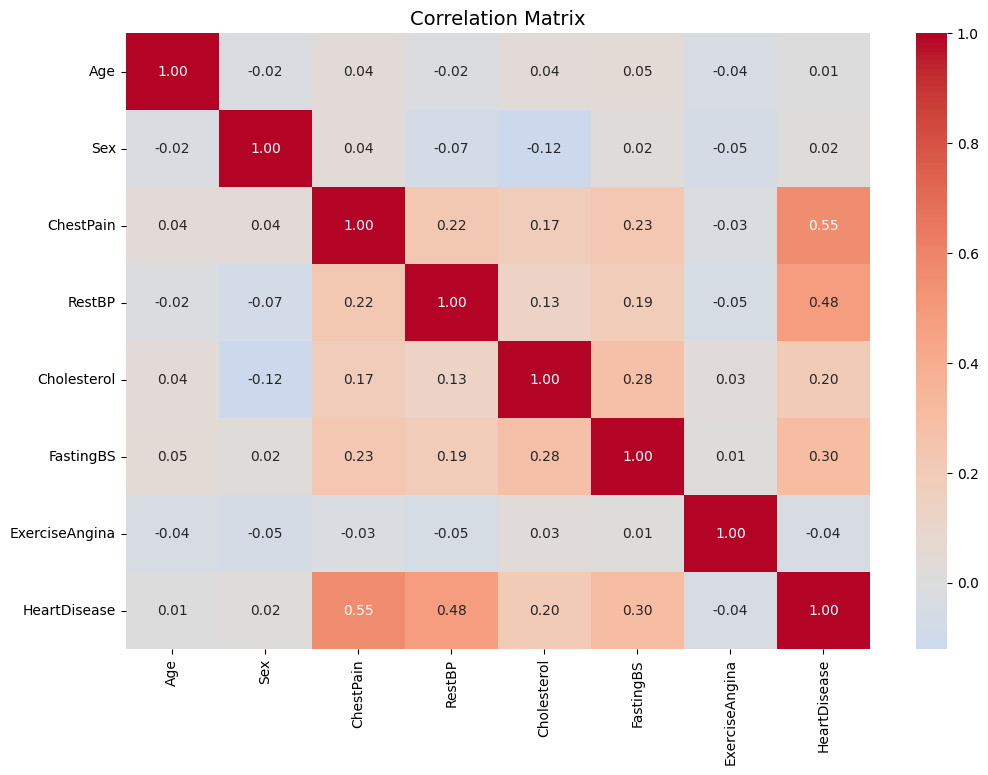

In [23]:
# CORRELATION
# Encode categorical features
le = LabelEncoder()
categorical_cols = df_winsorized.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df_winsorized[col] = le.fit_transform(df[col].astype(str))

# Calculate correlation
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix", fontsize=14)
plt.show()


In [24]:
# FINAL DATA
X = df.drop(columns=["HeartDisease"])
y = df_winsorized["HeartDisease"]

print("\n=== FINAL DATA ===")
print(f"Shape: {df_winsorized.shape}")
print(f"Feature Count: {len(X.columns)}")
print(f"Class Percentage:\n{y.value_counts(normalize=True)*100}")


=== FINAL DATA ===
Shape: (1000, 8)
Feature Count: 7
Class Percentage:
HeartDisease
1    58.0
0    42.0
Name: proportion, dtype: float64


# **B. SPLIT DATA**

In [25]:
# Split 70% for train
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split 30% remains, 30% * 0.33 = 9.9% => 10% for testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

# Proportion check
print(f'Train: {len(X_train)} samples')
print(f'Validation: {len(X_val)} samples')
print(f'test: {len(X_test)} samples')

from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Distribution after SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Train: 700 samples
Validation: 201 samples
test: 99 samples
Distribution after SMOTE:
HeartDisease
1    406
0    406
Name: count, dtype: int64


# **C. TRAIN MODEL**

In [26]:
# Evaluation function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluate_model(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    print(f"\n=== Evaluation {name} ===")

    y_train_pred = model.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    y_val_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    y_test_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

def plot_model(name, model):
  train_sizes, train_scores, val_scores = learning_curve(
      model, X_train, y_train, cv=5,
      train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
  )

  plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training')
  plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
  plt.title(f"Learning Curve - {name}")
  plt.xlabel('Training Size')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

# **1. Random Forest**


=== Evaluation Random Forest Before Tuning ===
Train Accuracy: 0.937192118226601
Validation Accuracy: 0.9402985074626866
Test Accuracy: 0.8383838383838383

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.82      0.79      0.80        42
           1       0.85      0.88      0.86        57

    accuracy                           0.84        99
   macro avg       0.84      0.83      0.83        99
weighted avg       0.84      0.84      0.84        99

Confusion Matrix:
 [[33  9]
 [ 7 50]]


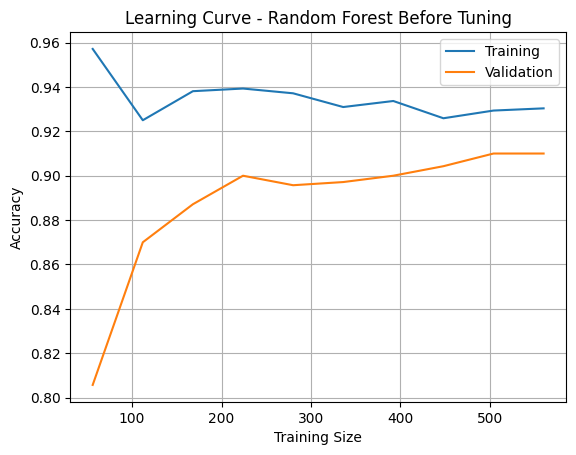

In [27]:
# Training data
# Prevent overfitting
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5, # 5 3
    min_samples_split=10, # 10 15
    min_samples_leaf=5, # 5 10
    max_features='sqrt', # 'sqrt' 0.5
    random_state=42
)

rf_model.fit(X_train_sm, y_train_sm)

# EVALUATION 1
evaluate_model("Random Forest Before Tuning", rf_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)

# EVALUATION 2
plot_model("Random Forest Before Tuning", rf_model)

# **DATA TUNING: RANDOM FOREST**

In [28]:

param_dist_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 0.3, 0.5, 0.7]
}

rf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=cv,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy'
)

random_search_rf.fit(X_train_sm, y_train_sm)

print("Best parameters (Random Forest):", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters (Random Forest): {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best score: 0.9372263879421343



=== Evaluation Random Forest After Tuning ===
Train Accuracy: 0.9975369458128078
Validation Accuracy: 0.945273631840796
Test Accuracy: 0.8686868686868687

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        42
           1       0.88      0.89      0.89        57

    accuracy                           0.87        99
   macro avg       0.87      0.86      0.87        99
weighted avg       0.87      0.87      0.87        99

Confusion Matrix:
 [[35  7]
 [ 6 51]]


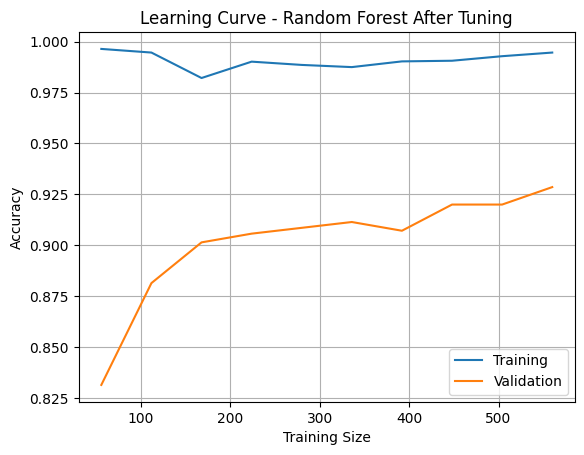

In [29]:
best_rf_model = random_search_rf.best_estimator_

best_rf_model.fit(X_train_sm, y_train_sm)

# EVALUATION 1
evaluate_model("Random Forest After Tuning", best_rf_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)

# EVALUATION 2
plot_model("Random Forest After Tuning", best_rf_model)

# **2. XGBoost**


=== Evaluation XGBoost Before Tuning ===
Train Accuracy: 0.9679802955665024
Validation Accuracy: 0.945273631840796
Test Accuracy: 0.8888888888888888

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.88      0.93      0.91        57

    accuracy                           0.89        99
   macro avg       0.89      0.88      0.89        99
weighted avg       0.89      0.89      0.89        99

Confusion Matrix:
 [[35  7]
 [ 4 53]]


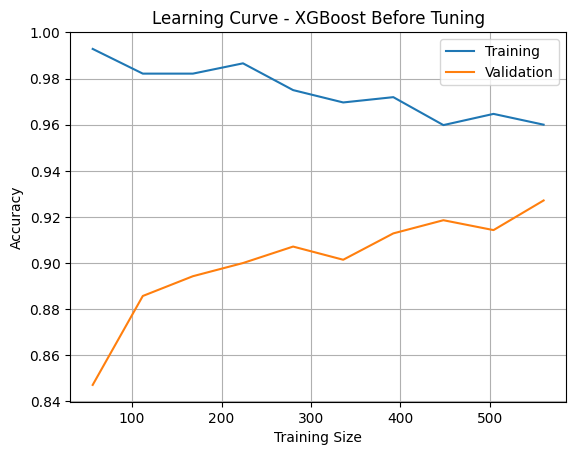

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    n_estimators=100, # 100 150
    max_depth=3, # 3 2
    learning_rate=0.1, # 0.1 0.05
    subsample=0.8, # 0.8 0.7
    colsample_bytree=0.5, # 0.5 0.3
    reg_alpha=0.1, # 0.1 0.5
    reg_lambda=1.0, # 1.0 1.5
    gamma=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_sm, y_train_sm)

# EVALUATION 1
evaluate_model("XGBoost Before Tuning", xgb_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)

# EVALUATION 2
plot_model("XGBoost Before Tuning", xgb_model)

# **DATA TUNING: XGBOOST**

In [31]:
param_dist_xgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0],
    'gamma': [0, 0.1, 0.3]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy'
)

random_search_xgb.fit(X_train_sm, y_train_sm)

print("Best parameters (XGBoost):", random_search_xgb.best_params_)
print("Best score:", random_search_xgb.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters (XGBoost): {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best score: 0.9396425054911763



=== Evaluation XGBoost After Tuning ===
Train Accuracy: 0.9778325123152709
Validation Accuracy: 0.9402985074626866
Test Accuracy: 0.898989898989899

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        42
           1       0.90      0.93      0.91        57

    accuracy                           0.90        99
   macro avg       0.90      0.89      0.90        99
weighted avg       0.90      0.90      0.90        99

Confusion Matrix:
 [[36  6]
 [ 4 53]]


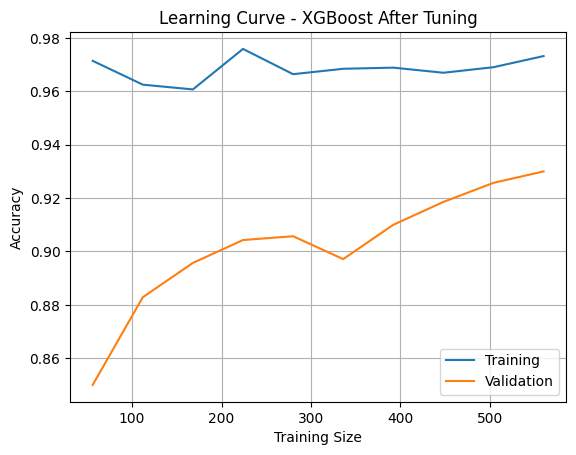

In [32]:
best_xgb_model = random_search_xgb.best_estimator_

best_xgb_model.fit(
    X_train_sm, y_train_sm
)

# EVALUATION 1
evaluate_model("XGBoost After Tuning", best_xgb_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)

# EVALUATION 2
plot_model("XGBoost After Tuning", best_xgb_model)

# **D. ADVANCED EVALUATION**

# **E. DEPLOYMENT**

In [33]:
# SAVE TO FILE
import joblib

joblib.dump(best_xgb_model, "xgb_heart_model.pkl")

['xgb_heart_model.pkl']

In [34]:
pip install streamlit

In [35]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd

# Load model
model = joblib.load("xgb_heart_model.pkl")

# Label Encoder mapping
gender_map = {'Male': 1, 'Female': 0}
chestpain_map = {'typical': 0, 'atypical': 1, 'non-anginal': 2, 'asymptomatic': 3}
exercise_map = {'Yes': 1, 'No': 0}

# Title
st.title("Prediksi Risiko Penyakit Jantung")

# Input from user
age = st.number_input("Umur", min_value=20, max_value=100, value=50)
sex = st.selectbox("Jenis Kelamin", ['Male', 'Female'])
restbp = st.number_input("Tekanan Darah Istirahat", min_value=80, max_value=200, value=120)
chol = st.number_input("Kadar Kolesterol", min_value=100, max_value=400, value=200)
fbs = st.selectbox("Gula Darah Puasa > 120 mg/dl", ['Yes', 'No'])
chestpain = st.selectbox("Jenis Nyeri Dada", list(chestpain_map.keys()))
exercise = st.selectbox("Angina karena Olahraga", list(exercise_map.keys()))

# COnvert input to model's format
input_data = np.array([[
    age,
    gender_map[sex],
    chestpain_map[chestpain],
    restbp,
    chol,
    1 if fbs == 'Yes' else 0,
    exercise_map[exercise]
]])

# Button
if st.button("Prediksi"):
    prob = model.predict_proba(input_data)[0][1]
    pred = model.predict(input_data)[0]
    st.success(f"Risiko penyakit jantung: {prob * 100:.2f}%")
    st.info("Status: " + ("Berisiko" if pred == 1 else "Tidak Berisiko"))


2025-07-11 13:12:02.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.498 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 13:12:02.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

SyntaxError: invalid syntax (ipython-input-36-507122745.py, line 1)